In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
import os, sys
sys.path.append('../functions')

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Read Data

In [4]:
data = pandas.read_csv('Data/hits.csv', index_col=0)
data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.


data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,Time,ELoss,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,250.000000,0.868600,0.868600,2581.1500,2581.1500,2581.1500,0,383.880371,5.310523e-06,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,249.507863,27.037487,-16.540384,3542.3793,3542.3793,3542.3793,0,415.954742,5.271870e-07,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,249.509850,-27.060200,16.517671,2592.3793,2592.3793,2592.3793,0,384.254303,3.097434e-06,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,249.203062,-23.553595,20.024276,2592.3793,2592.3793,2592.3793,1,384.251007,3.362202e-06,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,250.000000,-0.011400,-0.011400,2782.2500,2782.2500,2782.2500,0,390.597870,1.754228e-06,0


In [5]:
event_ids = numpy.unique(data.EventID.values)

In [6]:
X = data[['Wx1', 'Wy1', 'Wz1', 'Wx2', 'Wy2', 'Wz2', 'dist2Wire', 'DetectorID']].values
y = data[['EventID', 'Label']].values

# Tracks Reconstruction

In [7]:
from fast_hough import FastHough, Clusterer
from reconstruction import TracksReconstruction2D
from combination import Combinator


from metrics import TracksReconstractionMetrics, CombinatorQuality

In [52]:
from utils import merge_dicts

event_ids = event_ids
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = X[y[:, 0] == event_id]
    
    clustering=Clusterer(x_depth=2, y_depth=4, n_min=2)
    stm_y = FastHough(n_tracks=2, min_hits=3, k_size=0.7/4000, b_size=1700./4000, 
                      k_limits=(-0.35, 0.35), b_limits=(-850, 850), clustering=clustering, unique_hit_labels=True)
    stm_stereo = FastHough(n_tracks=1, min_hits=3, k_size=0.6/160, b_size=1000./160, 
                           k_limits=(-0.3, 0.3), b_limits=(-500, 500), clustering=clustering, unique_hit_labels=True)
    

    tr2d = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo, unique_hit_labels=True)
    tr2d.predict(event, None)
    
    track_inds12, tracks_params12 = tr2d.track_inds12_, tr2d.tracks_params12_
    track_inds34, tracks_params34 = tr2d.track_inds34_, tr2d.tracks_params34_
    
    comb = Combinator()
    comb.combine(tracks_params12, tracks_params34)
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'indeces12':track_inds12, 'params12':tracks_params12, 
                           'indeces34':track_inds34, 'params34':tracks_params34, 
                           'track_combs':comb.tracks_combinations_, 
                           'charges':comb.charges_, 
                           'pinvs':comb.inv_momentums_}
    
    return one_track

In [53]:
%%time
results = []
for i in event_ids:
    one_res = tracks_reconstruction(i)
    results.append(one_res)
tracks = merge_dicts(results)

CPU times: user 4.91 s, sys: 73.6 ms, total: 4.99 s
Wall time: 5.13 s


In [56]:
5.13 * 1000 / len(event_ids)

7.656716417910448

In [55]:
tracks[2]

{'charges': array([-1.,  1.]),
 'indeces12': array([[array([ 0,  3,  5,  7,  8, 10, 11, 29, 32]),
         array([ 1, 13, 18, 20, 22, 25, 27, 28, 31, 34])],
        [array([ 6,  9, 12, 14, 17, 23, 33]),
         array([ 2, 15, 16, 19, 21, 26, 30, 35])]], dtype=object),
 'indeces34': array([[array([ 8,  9, 10, 12, 13, 15, 16, 18, 20, 22, 28, 29]),
         array([ 2,  4,  6,  7, 24, 32, 35, 36, 38])],
        [array([11, 14, 17, 21, 23, 27, 30, 31, 33]),
         array([ 0,  1,  3,  5, 19, 25, 26, 34, 37])]], dtype=object),
 'params12': array([[[ -1.63213495e-03,   4.89566914e+00],
         [  1.34733568e-02,   3.81827865e+01]],
 
        [[  7.24606238e-03,  -1.49997507e+01],
         [  4.02654982e-04,   6.16276696e+01]]]),
 'params34': array([[[  1.53617729e-02,  -4.00637670e+01],
         [ -7.80644444e-03,   8.21718908e+01]],
 
        [[ -4.93879065e-03,   1.49294584e+01],
         [  1.88772534e-02,   1.80358740e+01]]]),
 'pinvs': array([-0.01469605,  0.03606462]),
 'track_combs'

In [75]:
%%time
tracks_metrics_before_y_data = []
tracks_metrics_before_stereo_data = []
tracks_metrics_before_all_data = []

tracks_metrics_after_y_data = []
tracks_metrics_after_stereo_data = []
tracks_metrics_after_all_data = []

combinations_data = []
combinations_true_data = []

combinations_quality_data = []

pass_stages_data = []

for event_id in tracks.keys():
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    track_inds12 = tracks[event_id]['indeces12']
    tracks_params12 = tracks[event_id]['params12']
    track_inds34 = tracks[event_id]['indeces34']
    tracks_params34 = tracks[event_id]['params34']
    track_combs = tracks[event_id]['track_combs']
    pinvs = tracks[event_id]['pinvs']
    charges = tracks[event_id]['charges']
    
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2, n_tracks=2)
    trm12.fit(track_inds12, event12)

    tracks_metrics_before_y_data += [[event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]]

    tracks_metrics_before_stereo_data += [[event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]]
    
    tracks_metrics_before_all_data += [[event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]]
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2, n_tracks=2)
    trm34.fit(track_inds34, event34)
    
    tracks_metrics_after_y_data += [[event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]]

    tracks_metrics_after_stereo_data += [[event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]]
    
    tracks_metrics_after_all_data += [[event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]]
    
        
    
    # Combination of the tracks before and after the magnet
    
    for num in range(len(track_combs)):
        
        combinations_data += [[event_id, 
                                               track_combs[num][0], 
                                               track_combs[num][1], 
                                               charges[num], 
                                               pinvs[num]]]
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(track_inds12, track_inds34, track_combs, charges, pinvs, event12, event34)
    
    combinations_quality_data += [[event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true_data += [[event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]]

    
    
    # Overall quality
    line = numpy.array([1, 
                         (trm12.recognition_efficiency_y_ == 1)*1, 
                         (trm12.recognition_efficiency_stereo_ >= 1)*1, 
                         (trm12.recognition_efficiency_ == 1)*1,
                         (trm34.recognition_efficiency_y_ == 1)*1, 
                         (trm34.recognition_efficiency_stereo_ >= 1)*1, 
                         (trm34.recognition_efficiency_ == 1)*1, 
                         (cq.n_combined_ >= 2)*1,
                         (cq.reco_eff_ == 1)*1]).cumprod()
    pass_stages_data += [numpy.concatenate(([event_id], line), axis=0)]


CPU times: user 3.7 s, sys: 21.4 ms, total: 3.73 s
Wall time: 3.75 s


In [78]:
tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'], 
                                           data=tracks_metrics_before_y_data)
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'], 
                                                data=tracks_metrics_before_stereo_data)
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'], 
                                             data = tracks_metrics_before_all_data)

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'], 
                                          data=tracks_metrics_after_y_data)
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'], 
                                               data=tracks_metrics_after_stereo_data)
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'], 
                                            data=tracks_metrics_after_all_data)

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'], 
                                data=combinations_data)
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'], 
                                     data=combinations_true_data)

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'], 
                                        data=combinations_quality_data)

pass_stages = pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'], 
                               data=pass_stages_data)

# Quality

# Stations 1&2

### Y-views

In [79]:
tracks_metrics_before_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.991835
RecoEff         0.996269
GhostRate       0.000000
CloneRate       0.001493
dtype: float64

### Stereo-views

In [80]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.989124
RecoEff         0.997015
GhostRate       0.000000
CloneRate       0.000746
dtype: float64

### Stations 1&2

In [81]:
tracks_metrics_before_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.989868
RecoEff         0.997761
GhostRate       0.000000
CloneRate       0.000000
dtype: float64

### Track efficiency

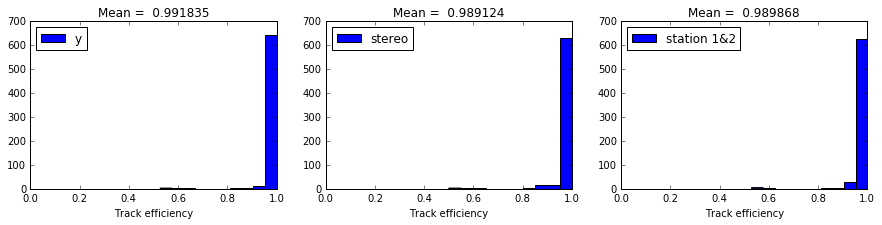

In [82]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

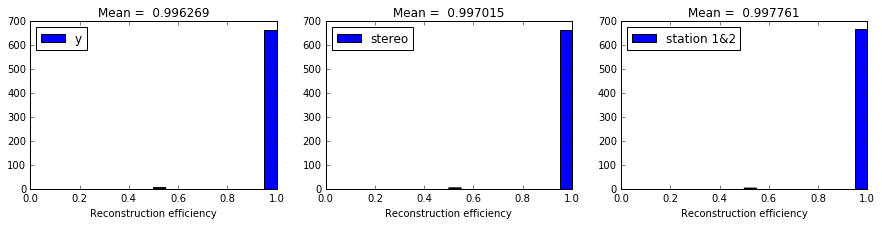

In [83]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [84]:
tracks_metrics_after_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.993800
RecoEff         0.992537
GhostRate       0.000000
CloneRate       0.000746
dtype: float64

### Stereo-views

In [85]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.992361
RecoEff         0.993284
GhostRate       0.000000
CloneRate       0.000000
dtype: float64

### Station 3&4

In [86]:
tracks_metrics_after_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.992625
RecoEff         0.993284
GhostRate       0.000000
CloneRate       0.000000
dtype: float64

### Tracks efficiency

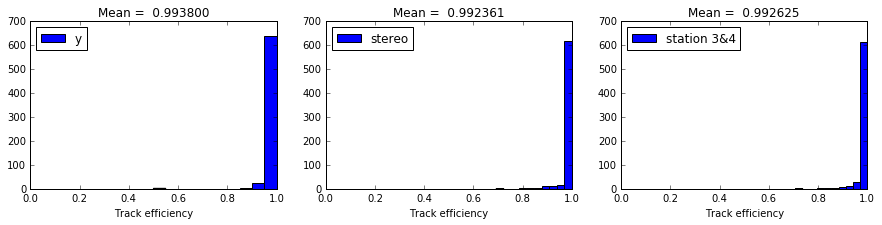

In [87]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

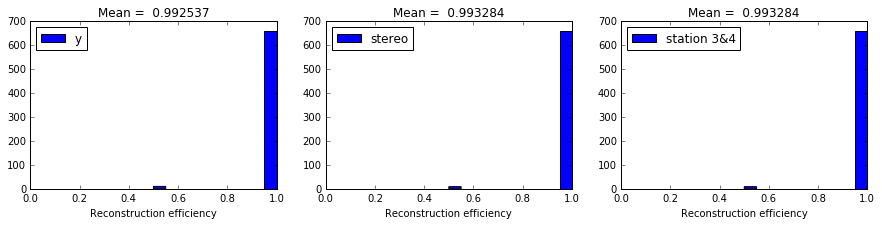

In [88]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [89]:
combinations_quality.mean(axis=0)

EventID      2555.164179
RecoEff         0.979104
GhostRate       0.001493
CloneRate       0.000000
NCombined       1.958209
dtype: float64

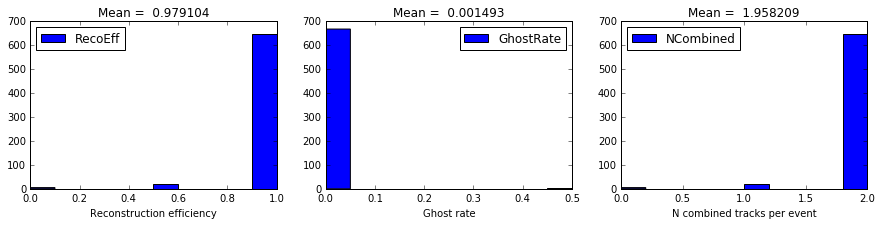

In [90]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
#plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
#plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

In [91]:
combinations_quality.head(5)

,EventID,RecoEff,GhostRate,CloneRate,NCombined
0,4097,1,0,0,2
1,2,1,0,0,2
2,4267,1,0,0,2
3,7,1,0,0,2
4,4453,1,0,0,2


# Ratio of the events passes through the stages

96.5671641791


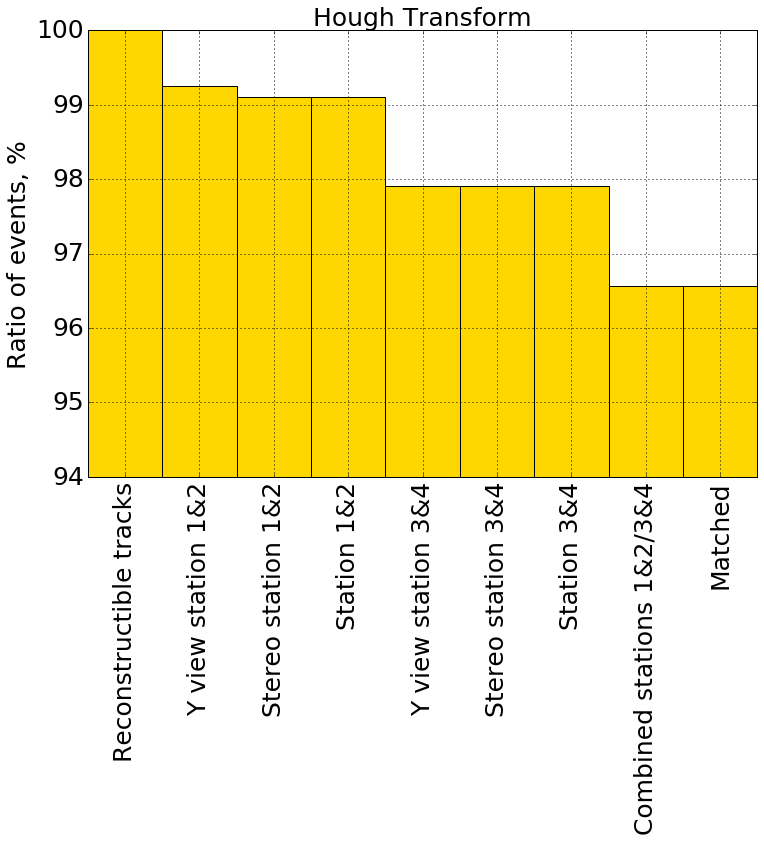

In [97]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages[pass_stages.columns[1:]].sum(axis=0).values
bar_values = 100. * bar_values / bar_values[0]


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(12,8))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(-0.5, 8.5)
plt.ylim(94, 100)
#plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=25)
plt.grid(linewidth=1)
plt.title('Hough Transform', size=25)
plt.show()

In [98]:
bar_values

array([ 100.        ,   99.25373134,   99.10447761,   99.10447761,
         97.91044776,   97.91044776,   97.91044776,   96.56716418,
         96.56716418])

In [105]:
#event_ids = numpy.unique(data.EventID.values)

def TotalEffVsTrackEff(event_ids, track_eff_cuts):

    total_efficiencies = []
    momentum_mae = []

    for cut in track_eff_cuts:

        combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                         'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

        pass_stages = []#pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                                #'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

        for event_id in event_ids:

            # Get an event
            event = data[data.EventID == event_id]
            event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
            event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]


            track_inds12 = tracks[event_id]['indeces12']
            tracks_params12 = tracks[event_id]['params12']
            track_inds34 = tracks[event_id]['indeces34']
            tracks_params34 = tracks[event_id]['params34']

            # Quality metrics of the reconstruction
            trm12 = TracksReconstractionMetrics(cut, n_tracks=2)
            trm12.fit(track_inds12, event12)

            # Quality metrics of the reconstruction
            trm34 = TracksReconstractionMetrics(cut, n_tracks=2)
            trm34.fit(track_inds34, event34)

            # Combination of the tracks before and after the magnet
            #comb = SuperCombinator(classifier=folding.estimators[0])
            comb = Combinator()
            comb.combine(tracks_params12, tracks_params34)


            # Quality of the combination
            cq = CombinatorQuality()
            cq.fit(track_inds12, track_inds34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)



            # Overall quality
            line = numpy.array([1, 
                                 (trm12.recognition_efficiency_y_ == 1)*1, 
                                 (trm12.recognition_efficiency_stereo_ >= 1)*1, 
                                 (trm12.recognition_efficiency_ == 1)*1,
                                 (trm34.recognition_efficiency_y_ == 1)*1, 
                                 (trm34.recognition_efficiency_stereo_ >= 1)*1, 
                                 (trm34.recognition_efficiency_ == 1)*1, 
                                 (cq.n_combined_ >= 2)*1,
                                 (cq.reco_eff_ == 1)*1]).cumprod()
            pass_stages += [numpy.concatenate(([event_id], line), axis=0)]

        pass_stages = numpy.array(pass_stages)
        bar_values = pass_stages[:, 1:].sum(axis=0)
        bar_values = 100. * bar_values / bar_values[0]

        total_eff = bar_values[-1]
        total_efficiencies.append(total_eff)

    total_efficiencies = numpy.array(total_efficiencies)

    return total_efficiencies

In [106]:
%%time
track_eff_cuts = numpy.linspace(0, 1., 11)
total_efficiencies = TotalEffVsTrackEff(event_ids, track_eff_cuts)

CPU times: user 45.3 s, sys: 470 ms, total: 45.8 s
Wall time: 47.1 s


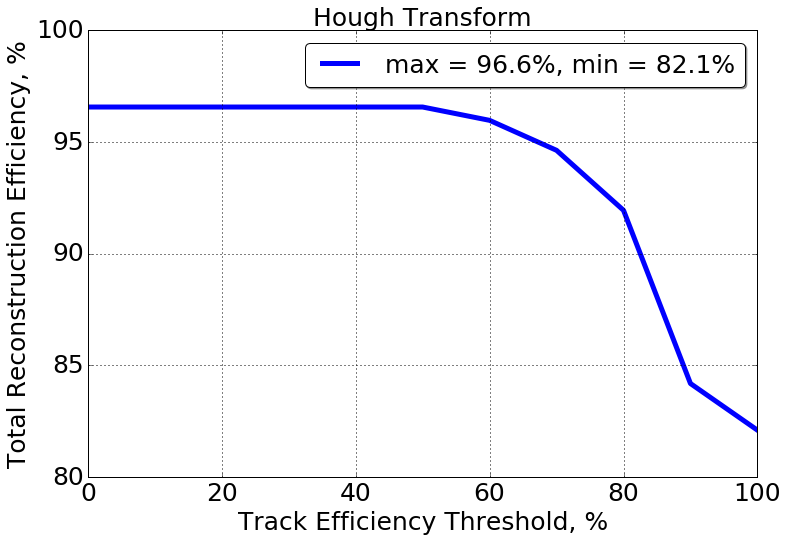

In [107]:
plt.figure(figsize=(12, 8))
l = 'max = ' + str(numpy.round(total_efficiencies[0], 1)) + '%, ' + 'min = ' + str(numpy.round(total_efficiencies[-1], 1)) + '%'
plt.plot(track_eff_cuts*100, total_efficiencies, linewidth=5, label=l)
plt.legend(loc="best", prop={'size':25},  shadow=True, fancybox=True)
plt.title("Hough Transform", fontsize=25)
plt.xlabel('Track Efficiency Threshold, %', fontsize=25)
plt.ylabel('Total Reconstruction Efficiency, %', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(80, 100)
plt.xlim(0., 100.)
plt.grid(linewidth=1)
plt.show()

# Momentum

In [108]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

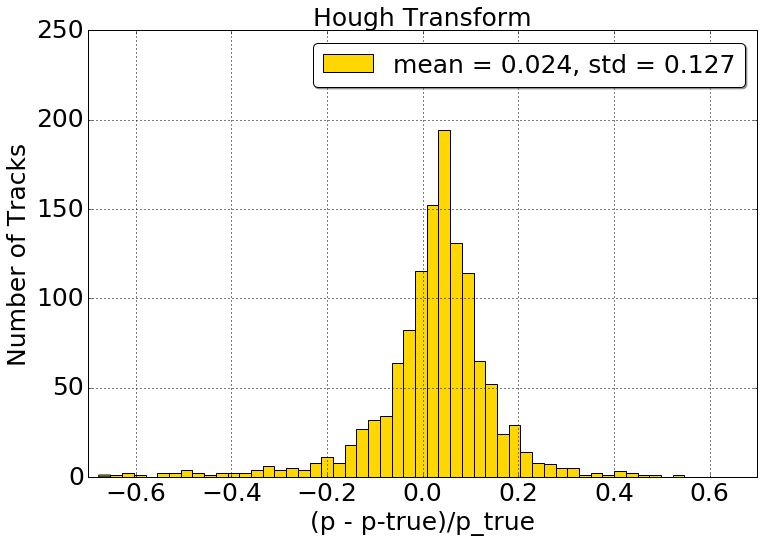

In [109]:
plt.figure(figsize=(12, 8))
q = -p_err[numpy.isfinite(p_err)*(numpy.abs(p_err)<=0.7)]
l = 'mean = ' + str(numpy.round(q.mean(), 3)) + ', std = ' + str(numpy.round(q.std(), 3))
plt.hist(q, bins=50, normed=False, label=l, color='gold')
#plt.hist(p_err[numpy.isfinite(p_err)], bins=50)

plt.title('Hough Transform', size=25)
plt.legend(loc="best", prop={'size':25},  shadow=True, fancybox=True)
#plt.title("TrackEff vs RecoEff", fontsize=25)
plt.xlabel('(p - p-true)/p_true', fontsize=25)
plt.ylabel('Number of Tracks', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0, 250)
plt.xlim(-0.7, 0.7)
plt.grid(linewidth=1)
plt.show()

In [110]:
len(p_err) - len(p_err[numpy.isfinite(p_err)])

1

In [111]:
print numpy.abs(p_err[numpy.isfinite(p_err)]).mean() * 100

9.9196741497


# Did not recognized tracks

In [112]:
pass_stages[pass_stages.Matching.values == 0]

,EventID,RecoEvents,Y12,Stereo12,Stations12,Y34,Stereo34,Stations34,Combination,Matching
9,3085,1,0,0,0,0,0,0,0,0
54,85,1,1,1,1,1,1,1,0,0
61,3165,1,1,1,1,1,1,1,0,0
95,143,1,1,1,1,0,0,0,0,0
168,4342,1,1,1,1,1,1,1,0,0
184,270,1,1,1,1,0,0,0,0,0
229,4580,1,0,0,0,0,0,0,0,0
236,3781,1,1,1,1,0,0,0,0,0
267,4490,1,1,1,1,0,0,0,0,0
334,1528,1,1,1,1,0,0,0,0,0


In [113]:
bad_events = pass_stages[pass_stages.Matching.values == 0]['EventID'].values

3085


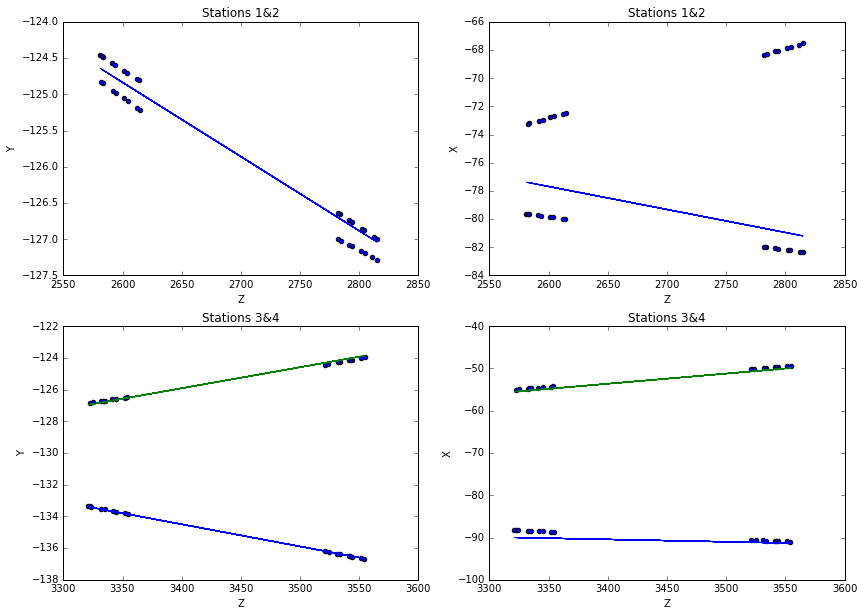

85


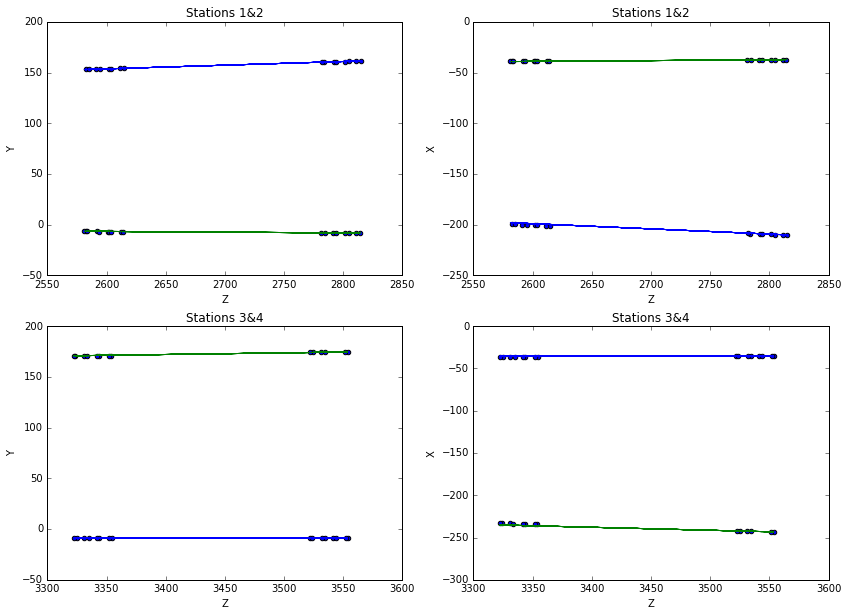

3165


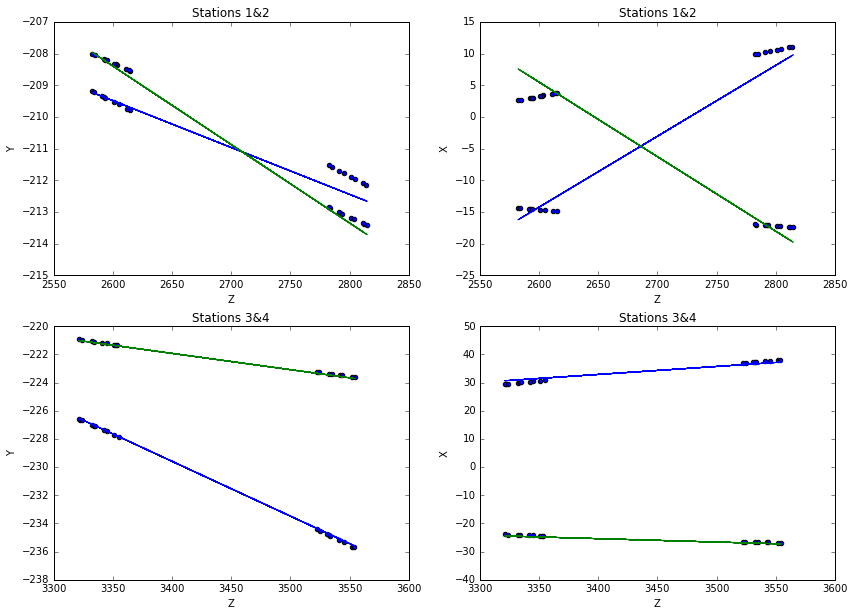

143


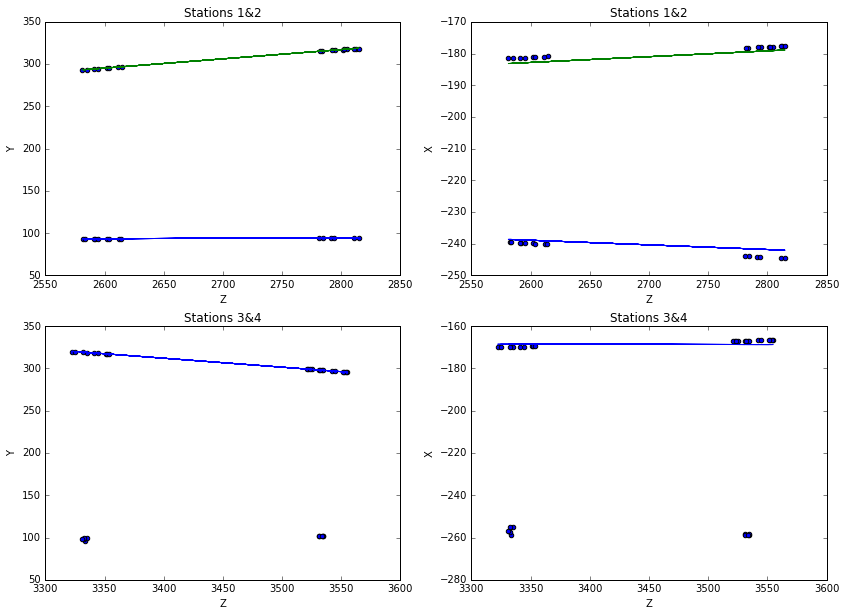

4342


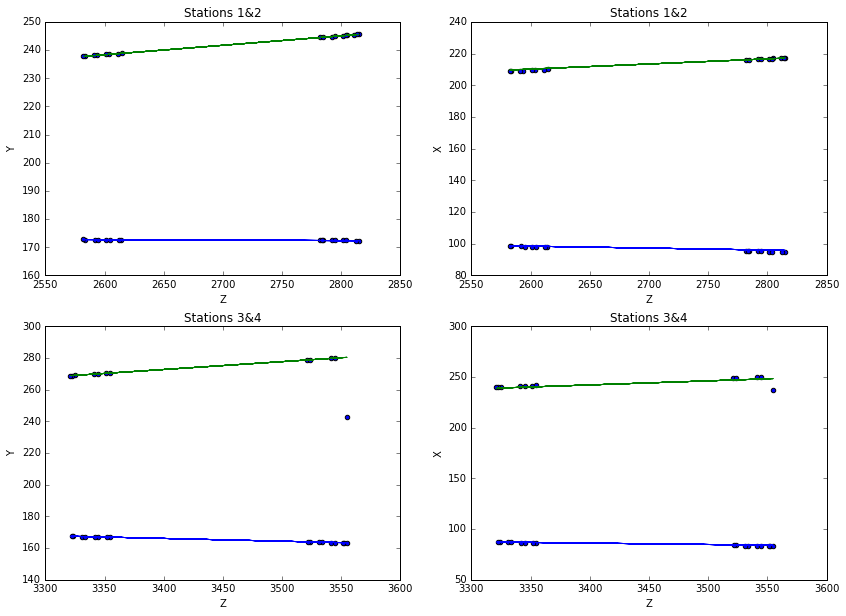

270


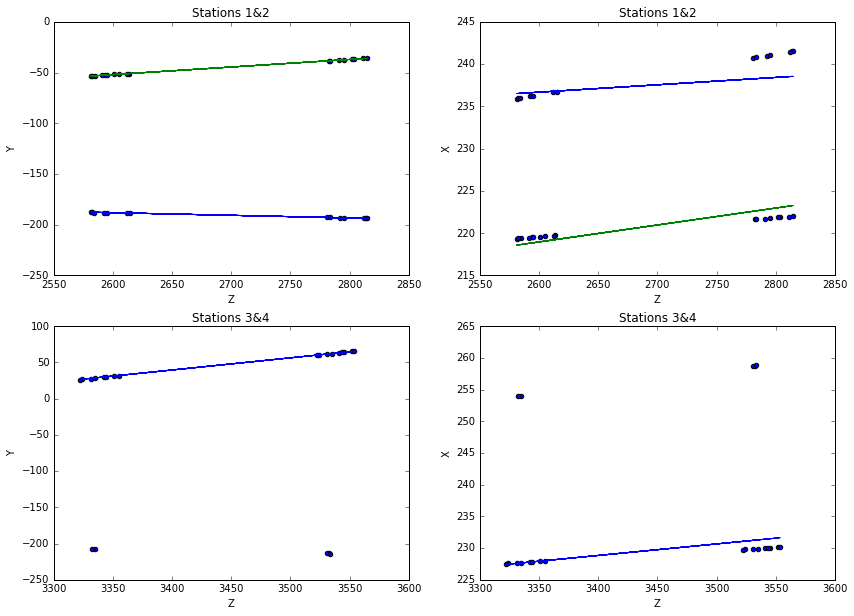

4580


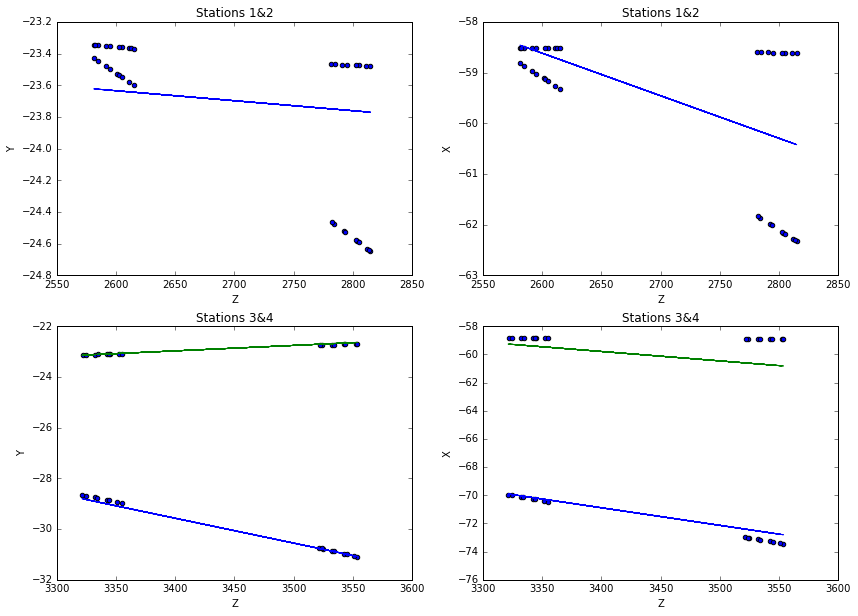

3781


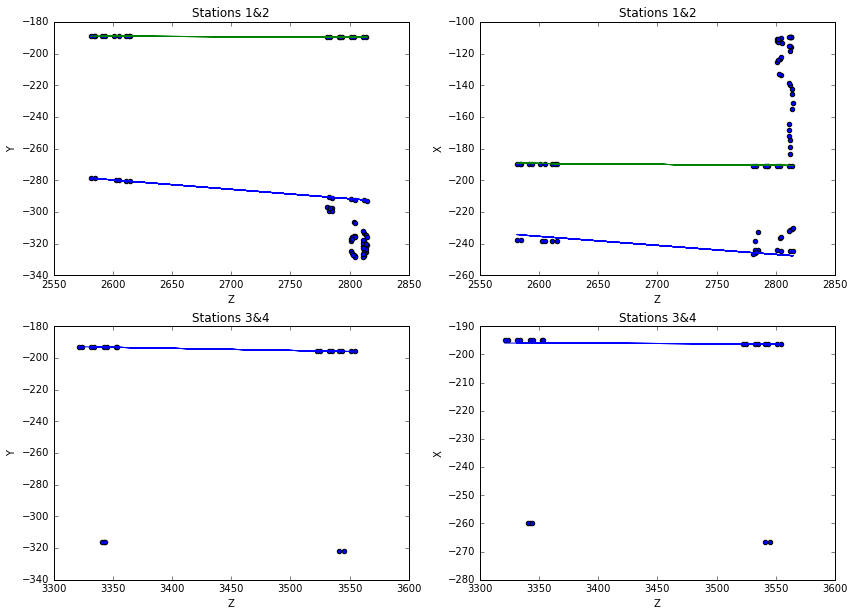

4490


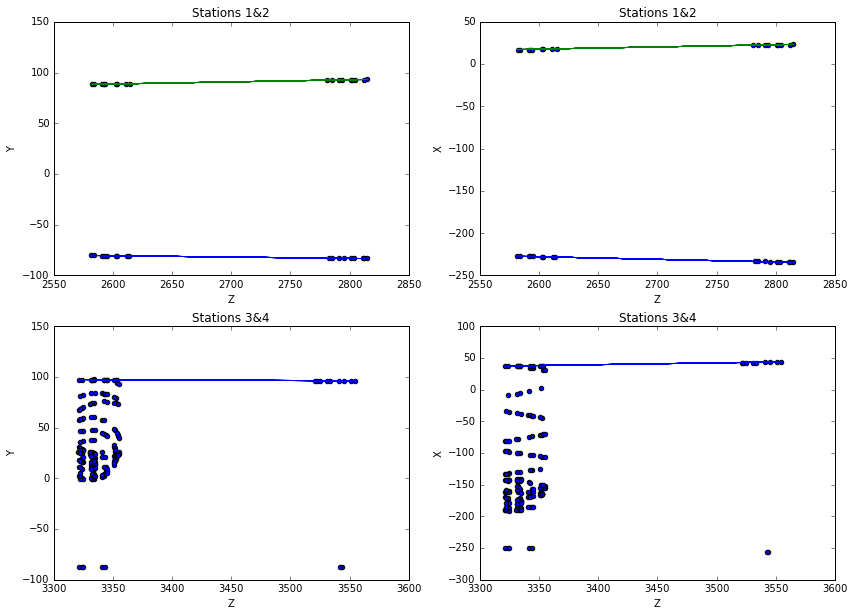

1528


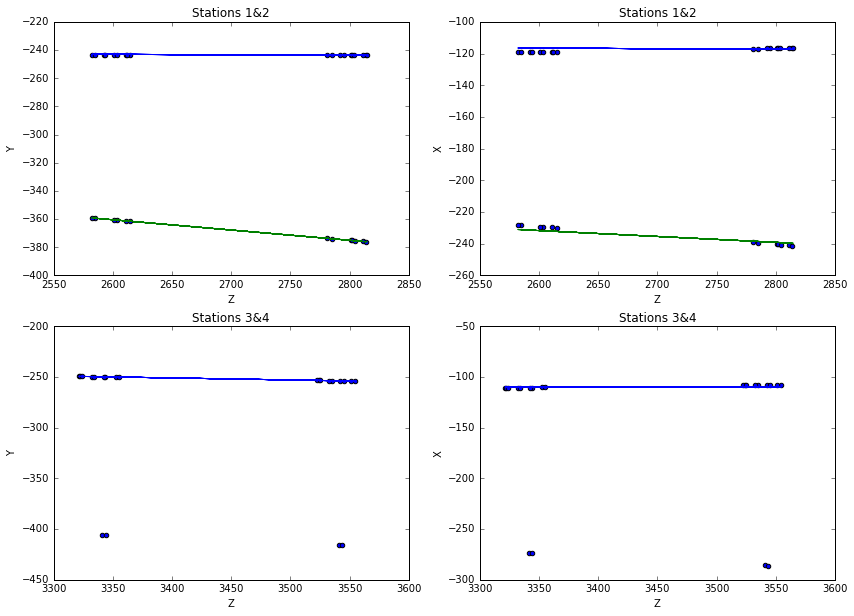

2605


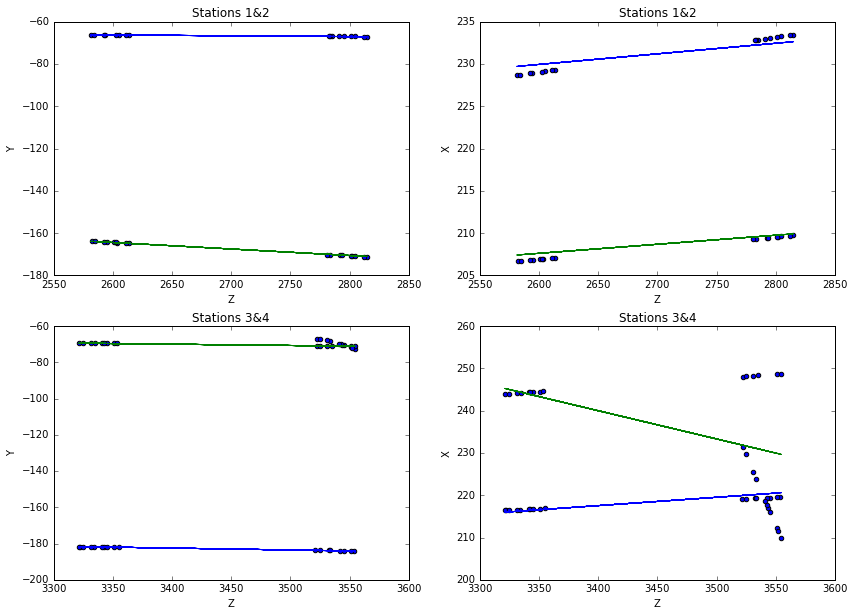

3670


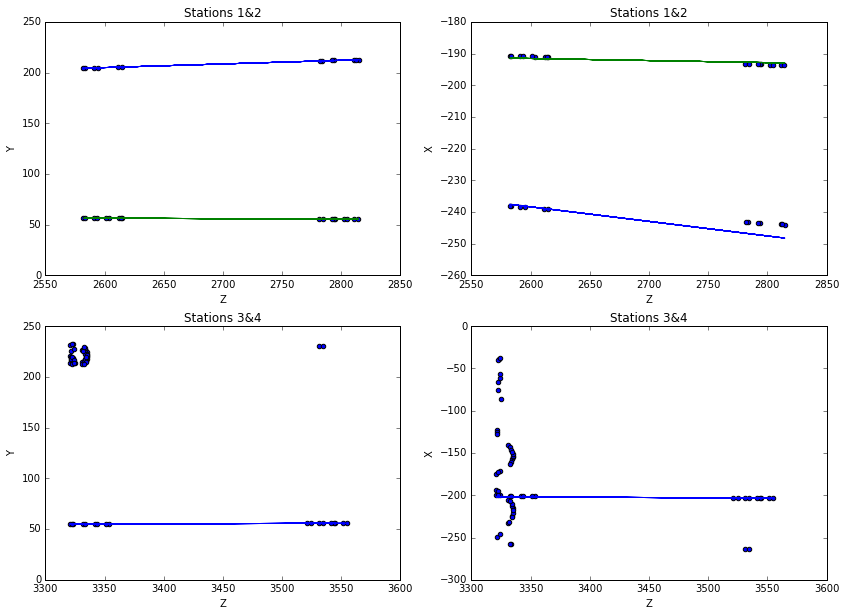

3498


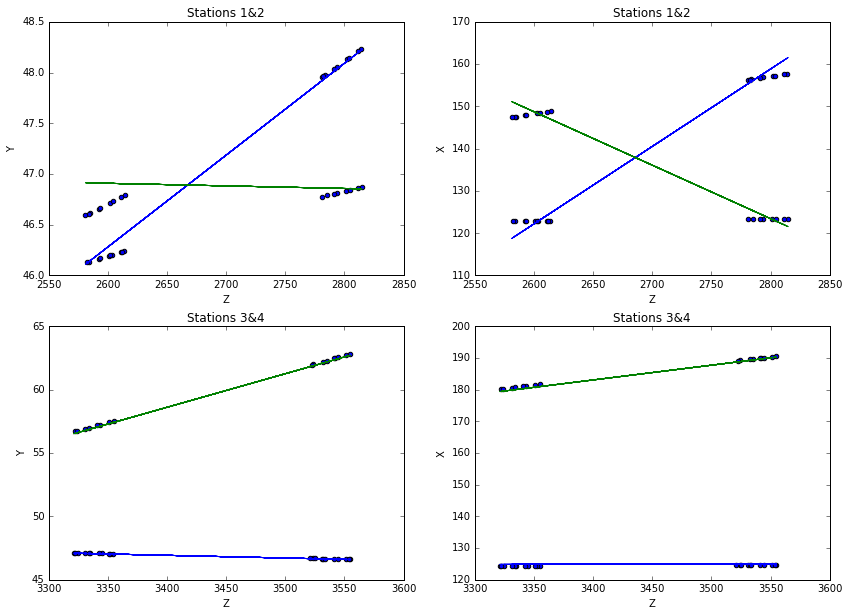

2685


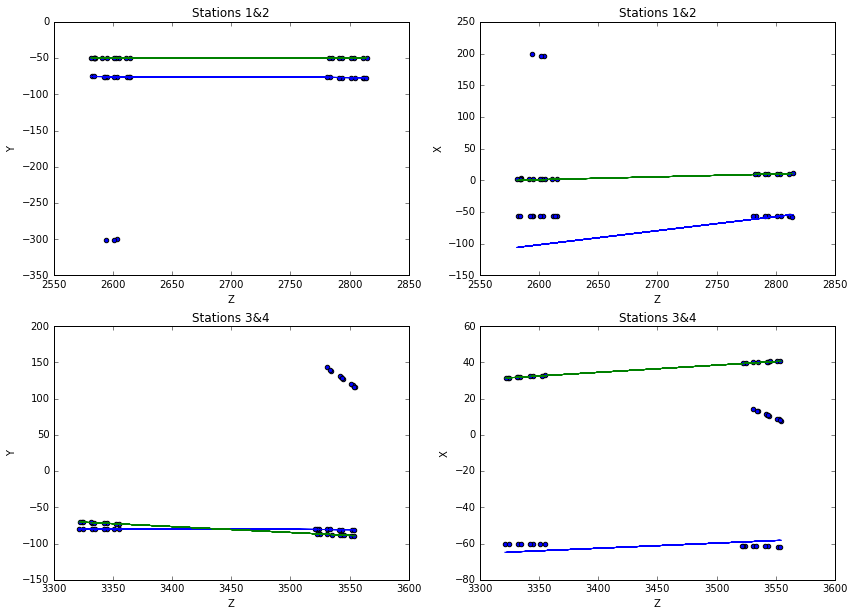

3749


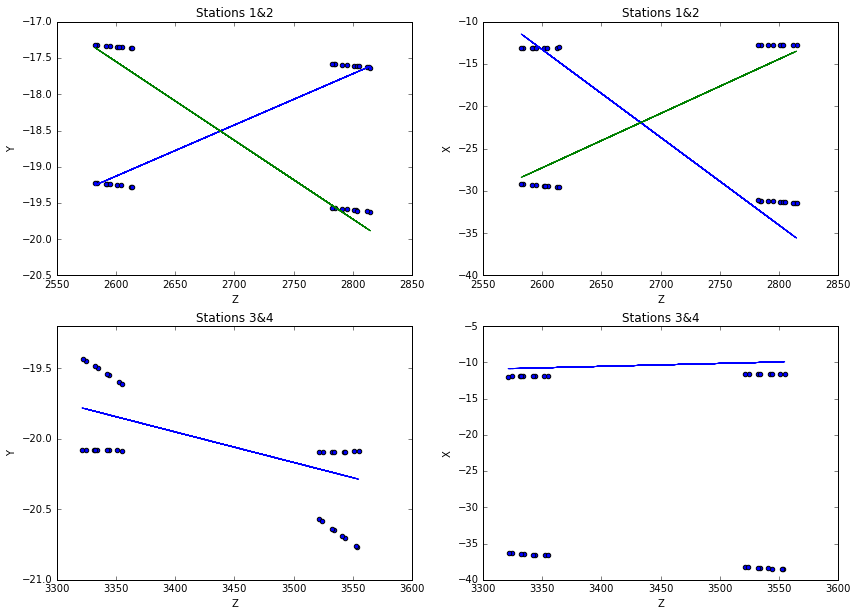

1722


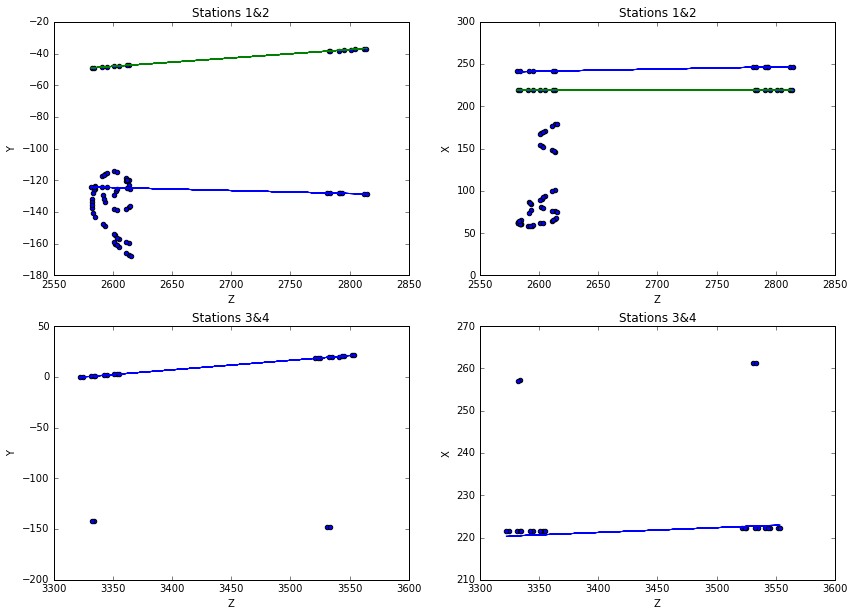

2762


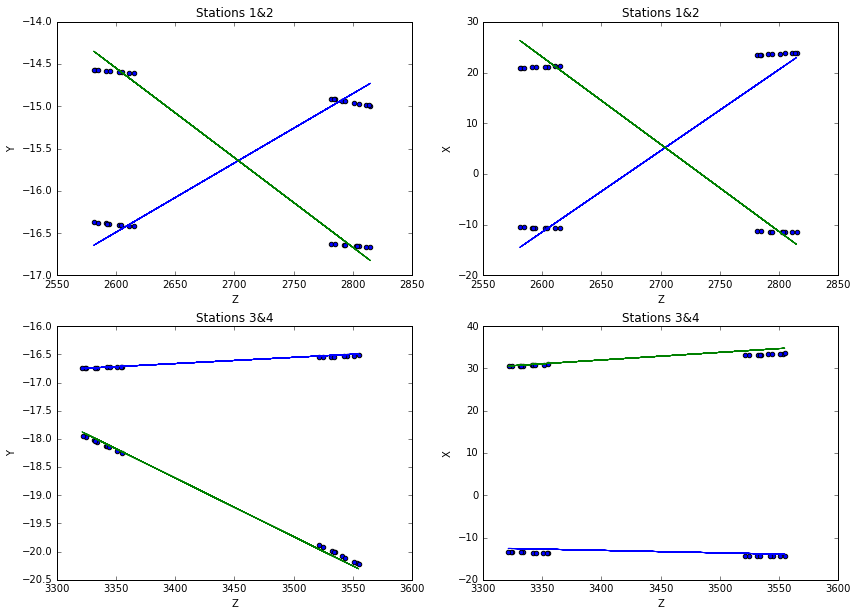

1756


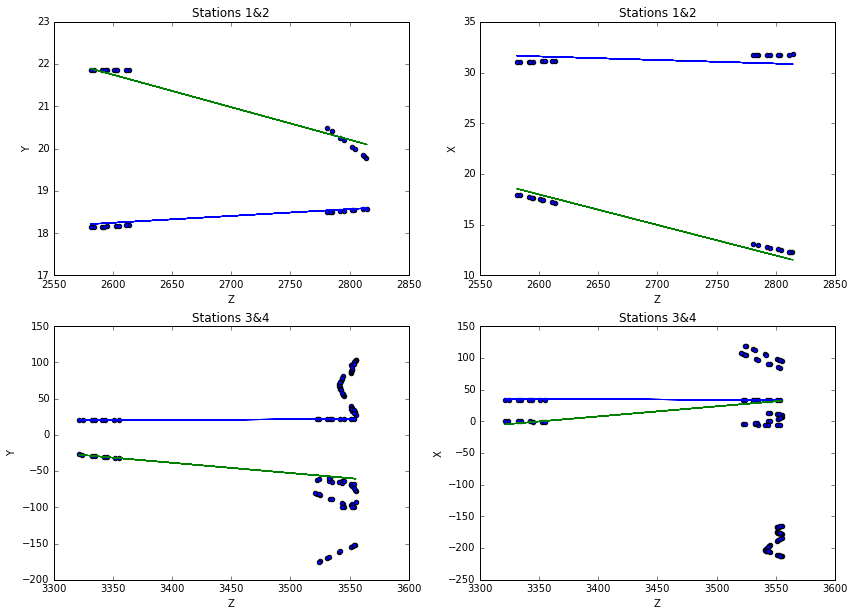

1769


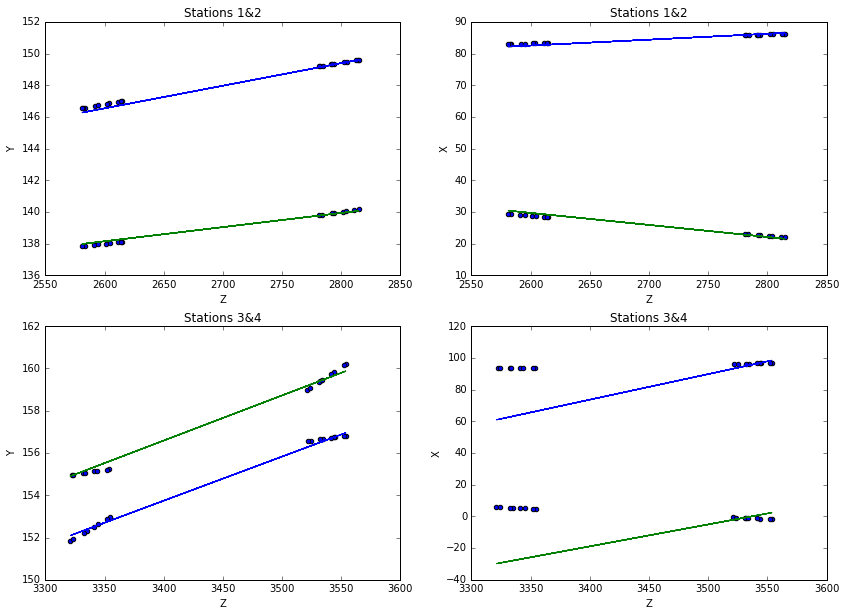

1848


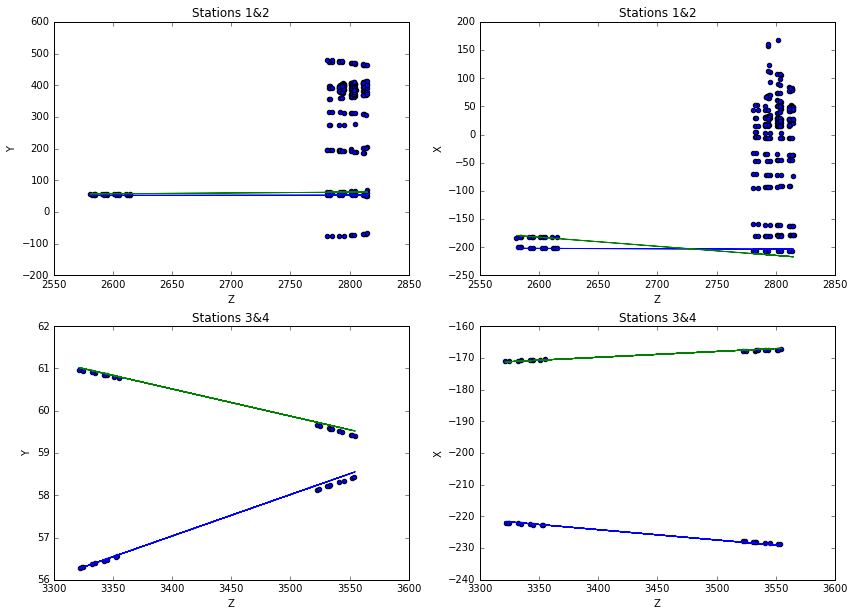

916


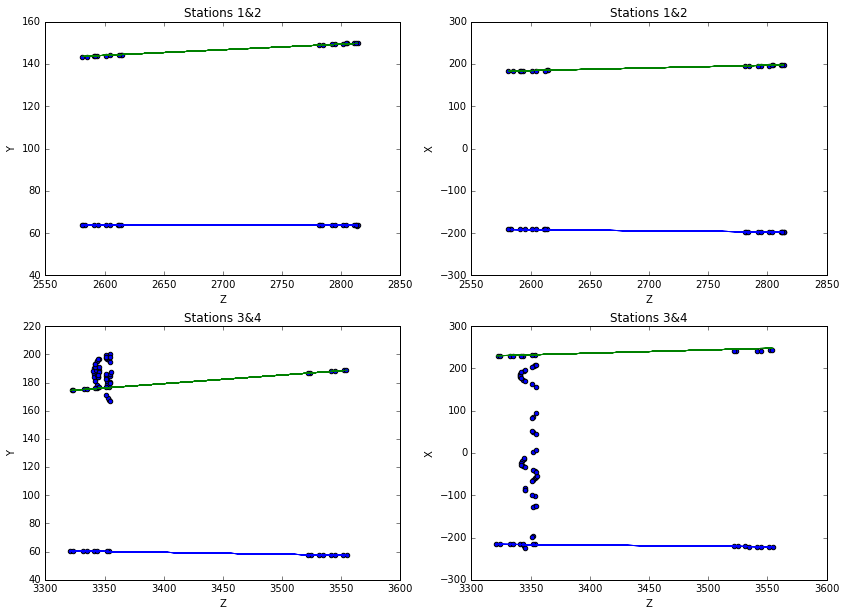

3916


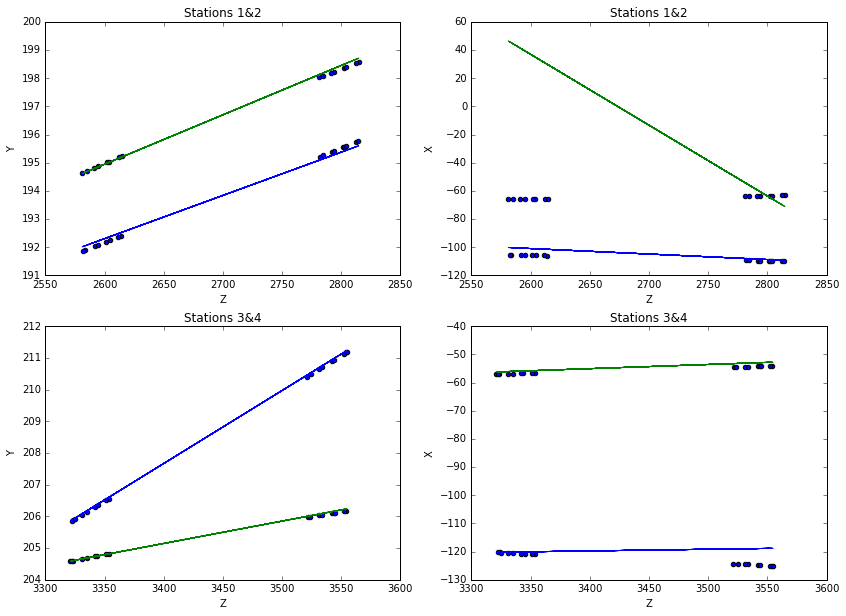

2040


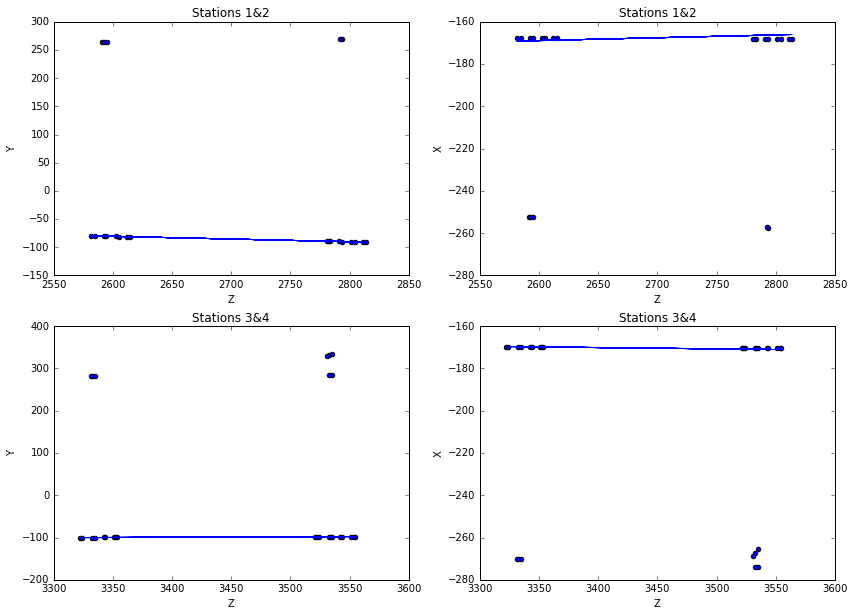

In [114]:
from utils import plot_event

for event_id in bad_events:
    print event_id
    plot_event(event_id, data, tracks)